In [1]:
import glob
import os

## sound preparation, feature extraction, preprocessing
import librosa
import librosa.display as disp
import soundfile as sf

## math and charts
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import math

## some time measurement
import time

## data read/write with hdf5 files
import h5py

## random lmao
from random import shuffle

from pympler.tracker import SummaryTracker
tracker = SummaryTracker()

In [2]:
#hop 10ms, window 40
pitchVolumes = [-2, -1, 1, 2]

def appendTracks(data,labels,paths,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 22050)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=512,  win_length=1024))**2
    mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=22050, n_mels = 128),ref_power= np.max)
    delta  = librosa.feature.delta(mel)
    outData = np.array([mel,delta])
    outData = np.swapaxes(outData, 0, 2)
    outData = np.swapaxes(outData, 0, 1)
    data.append(outData)
    labels.append(classNumber)
    paths.append(fp)
    pitches = 1
#     for pitch in pitchVolumes:
#         temp = librosa.effects.pitch_shift(sound, 44100, pitch)
#         D = np.abs(librosa.stft(temp, hop_length=1024,  win_length=1024))**2
#         mel = librosa.logamplitude(librosa.feature.melspectrogram(S=D, sr=44100, n_mels = 128),ref_power= np.max)
#         newFp = fp.split('.')
#         newFp[0] += ('-pitch'+str(pitches)+'.')
#         newFp=''.join(newFp)
#         pitches += 1
#         data.append(mel)
#         labels.append(classNumber)
#         paths.append(newFp)
        

In [81]:
data, labels, paths = [], [], []
fp = "fold1/7383-3-0-0.wav"
appendTracks(data, labels, paths, fp)
print (data[0].shape)


(128, 173, 2)


In [3]:
p

I'm done, time was: 406.81693387


In [66]:
# splits data to train and test arrays, optional tune.
# arrays are given in form of trainData, trainLabels...
# method shall be fed with step between windows (equivalent to their width) and lists of folds that shall create 
# train, (tune), test arrays

# train and tune arrays split tracks into windows of widht = spltStep, test array preserves whole track

def split (splitStep, dataset, *data):
    
    with h5py.File(dataset +".hdf5") as f:
        
        #no tune set
        if len(data) == 2:
            trainData, trainLabels, testData, testLabels = [],[],[],[]
            
            #create train arrays
            for fold in data[0]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    tempTrack = grp[track][()]
                    classNumber = grp[track].attrs['class']
                    iterator = 0

                    while iterator + splitStep <= tempTrack.shape[1]:
                        trainData.append(tempTrack[: ,iterator : iterator + splitStep,:])
                        trainLabels.append(classNumber)
                        iterator += splitStep
            
            #create test arrays         
            for fold in data[1]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    if track.split('.')[0].split('-')[-1][:-1] == 'pitch':
                        continue
                        
                    testData.append(grp[track][()])
                    testLabels.append(grp[track].attrs['class'])
                    
            return trainData, trainLabels, testData, testLabels
                 
        # with tune set
        elif len(data) == 3:
            trainData, trainLabels, tuneData, tuneLabels, testData, testLabels = [],[],[],[],[],[]
            
            # create train arrays
            for fold in data[0]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    tempTrack = grp[track][()]
                    classNumber = grp[track].attrs['class']
                    
                    iterator = 0
                    
                        
                    while iterator + splitStep <= tempTrack.shape[1]:
                        trainData.append(tempTrack[: ,iterator : iterator + splitStep,:])
                        trainLabels.append(classNumber)
                        iterator += splitStep
                        
            # create tune arrays
            for fold in data[1]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    if track.split('.')[0].split('-')[-1][:-1] == 'pitch':
                        continue
                    tempTrack = grp[track][()]
                    classNumber = grp[track].attrs['class']
                    
                    
                    iterator = 0
                    while iterator + splitStep <= tempTrack.shape[1]:
                        tuneData.append(tempTrack[: ,iterator : iterator + splitStep,:])
                        tuneLabels.append(classNumber)
                        iterator += splitStep
            
            # create test arrays
            for fold in data[2]:
                grp = f['fold' + str(fold)]
                
                for track in grp.keys():
                    
                    if track.split('.')[0].split('-')[-1][:-1] == 'pitch':
                        continue
                    
                    testData.append(grp[track][()])
                    testLabels.append(grp[track].attrs['class'])
            
            return trainData, trainLabels, tuneData, tuneLabels, testData, testLabels

        else:
            raise NameError("Wrong number of inputs")

In [79]:
## predicts classes on whole database or specified fold from database
def predictOnDataBase(model, splitStep, dataset, *data):
    with h5py.File(dataset +".hdf5") as f:
        ## prepare list of folds to work on
        grps = []
        if len(data) == 0:
            for grp in f:
                grps.append(f[grp])
        else:
            if type(data[0]) is list:
                for fold in data[0]:
                    grps.append(f['fold' + str(fold)])
            else:
                for fold in data:
                    grps.append(f['fold' + str(fold)])
        
        ## assign scores to every file in fold        
        for grp in grps:
            for clip in grp.keys():
                clip = grp[clip]
                if 'predictions' in clip.attrs:
                    del clip.attrs['predictions']
                
                temp = clip[()]
                trackToPredict = []
                iterator = 0

                    
                ## if clip is too short to predict even 1 window, expand it
                if temp.shape[1]<splitStep:
                    t = temp.shape[1]
                    b = np.zeros((temp.shape[0],splitStep,2))
                    b[:, :-splitStep+t,:]= temp
                    trackToPredict.append(b)
                else:
                    ## iterate through clip and split it into windows
                    while iterator + splitStep <= temp.shape[1]:
                        trackToPredict.append(temp[: ,iterator : iterator + splitStep,:])
                        iterator += splitStep
                    
                ## prepare clip as a corrent CNN input and predict probabilities
                trackToPredict= np.array(trackToPredict)
                #trackToPredict = np.expand_dims(trackToPredict, axis=3)
                predicted = model.predict(trackToPredict, batch_size=1, verbose=2)

                ## predicted is a matrix of probabilities, where each row has 10 probabilities of being
                ## specific class, each row represents one predicted window
                
                ## to predictions append list of best prediction of class for each window
                ## predicted is majority vote over all windows (but voted using probabilities, not classes)
                clip.attrs['predictions']=np.argmax(predicted,axis=1)
                clip.attrs['predicted']=predicted.sum(axis=0).argmax()
        
            

In [23]:
## prints score and accuracy matrix for whole dataset or for given folds
def getScores(dataset, *data):
    scores = np.zeros((10,10))
    with h5py.File(dataset + ".hdf5") as f:
        grps = []
        ## prepare folds to print scores for
        if not data:
            for grp in f:
                grps.append(f[grp])
        else:
            if type(data[0]) is list:
                for fold in data[0]:
                    grps.append(f['fold' + str(fold)])
            else:
                for fold in data:
                    grps.append(f['fold' + str(fold)])

        for grp in grps:
            for clip in grp.keys():
                clip = grp[clip]

                scores[clip.attrs['predicted'],clip.attrs['class']] += 1
                
                
            
    ## returns confusion matrix (where rows are predicted classes and columns are actuall classes)
    ## as well as accuracy 
    return scores, scores.trace()/scores.sum()
                    
        

In [24]:
## look for clips searching for class or/and prediction
def findClips(dataset, actual = None, predicted = None, folds = None):
    if actual == None and predicted == None:
        print ("Specify actual or predicted classes to search for")
        return None
    if actual != None:
        if type(actual) is not list:
            temp = actual
            actual = []
            actual.append(temp)
        actual = set(actual)
    if predicted != None:
        if type(predicted) is not list:
            temp = predicted
            predicted = []
            predicted.append(temp)
        predicted = set(predicted)
        
    
    
    toReturn =[]
    grps =[]
    
    with h5py.File(dataset + ".hdf5") as f:
        if folds == None:
            for grp in f:
                grps.append(f[grp])
        else:
            for fold in folds:
                grps.append('fold' + str(fold))
                    
        if actual and predicted:
            for fold in grps:
                fold = f[fold]
                for clip in fold:
                    clip = fold[clip]
                    if clip.attrs['class'] in actual and clip.attrs['predicted'] in predicted:
                        toReturn.append(clip.name)
                    
        elif actual:
            for fold in grps:
                fold = f[fold]
                for clip in fold:
                    clip = fold[clip]
                    if clip.attrs['class'] in actual:
                        toReturn.append(clip.name)
                        
        elif predicted:
            for fold in grps:
                fold = f[fold]
                for clip in fold:
                    clip = fold[clip]
                    if clip.attrs['predicted'] in predicted:
                        toReturn.append(clip.name)
    
    return toReturn

                

In [25]:
## show spectrogram of given file
def showClip(fPath, dataset):
    with h5py.File(dataset+".hdf5") as f:
        clip = f[fPath]
        print (fPath)
        print (clip[()].shape[1])
        disp.specshow(clip[()])
        plt.show()

In [9]:
## NO PROPER DATA PREPARATION FOR THIS PART RIGHT NOW, GIVES POOR SCORES ANYWAY
## PROCEED TO CNN PART


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import regularizers
from random import uniform
from math import pow
rates2 = []

#standard NN - was fine tuned for another example, outdated right now

LR,L2= 0.008,0.00207
net = Sequential()
net.add(Dense(512, activation='relu', input_dim=1024,
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.5))
net.add(Dense(256, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.3))
net.add(Dense(64, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.1))
net.add(Dense(10, activation='softmax'))
net.compile(loss='categorical_crossentropy',
           optimizer = SGD(lr=LR,decay=1e-6, momentum=0.9,nesterov=True),
           metrics = ['accuracy'])

net.fit(trainData, trainLabels, epochs = 100, batch_size=128, verbose=0)
rates2.append([net.evaluate(tuneData,tuneLabels, batch_size=16384)[1],
             net.evaluate(trainData,trainLabels, batch_size=16384)[1],
             LR,L2])
print ("Tune score: %.3f Train score: %.3f Learning rate: %f L2 reg: %f" %(rates2[-1][0],rates2[-1][1],LR, L2))

Using TensorFlow backend.


NameError: name 'trainData' is not defined

In [70]:
## prepare data for CNN training

## split folds into train, tune and test sets
trainData, trainLabels, tuneData, tuneLabels, testData, testLabels = split(41, "piczakData", [1,2,3,4,5,6,7],[8],[9,10])

## lists to np arrays
trainData=np.array(trainData)
trainLabels=np.array(trainLabels)
tuneData=np.array(tuneData)
tuneLabels=np.array(tuneLabels)


## add 3rd dim - channel required by conv layers
# trainData=np.expand_dims(trainData,axis=3)
# tuneData=np.expand_dims(tuneData,axis=3)

from keras import utils

## classes to vector - one hot encode
trainLabels = np.array(utils.to_categorical(trainLabels, num_classes=10))
tuneLabels = np.array(utils.to_categorical(tuneLabels, num_classes=10))

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D,BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

#CNN working on batches of image, accuracy up to 72%
def regularNet(drop,l2,lr,batch):

    model = Sequential()
    model.add(ZeroPadding2D(padding = (1,1), input_shape=(64, 16, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 4)))
    model.add(ZeroPadding2D(padding = (1,1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(ZeroPadding2D(padding = (1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Dropout(drop))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(drop))
    model.add(Dense(10, activation='softmax'))


    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

    trSc =[]
    tuSc =[]
    ls=[]
    for x in xrange(30):
        history =model.fit(trainData, trainLabels, batch_size=batch, epochs=1,verbose=1)
        #predictOnDataBase(model,16, "wholeTracks",8 )
        trSc.append(history.history['acc'])
        ls.append(history.history['loss'])
        #tuSc.append(getScores("wholeTracks", 8)[1])
        tuSc.append(model.evaluate(tuneData, tuneLabels))
    tuSc = np.array(tuSc)
        
        
    directory="piczak/" + str(drop).replace(".","")+"/l2"+str(l2).replace(".","")+"/lr"+str(lr).replace(".","")+"/batch"+str(batch)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.clf()
    plt.cla()
    plt.close()    
    plt.plot(trSc)
    plt.plot(tuSc[:,1])
    plt.title('Model accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig(directory+"/accuracy.png")
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    plt.plot(ls)
    plt.title('Model loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    #plt.savefig(directory+"/loss.png")
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    
    return trSc, tuSc, ls
    

In [75]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D,BatchNormalization
from keras.optimizers import SGD
from keras import regularizers

#PICZAK
def regularNet(drop,l2,lr,batch):

    model = Sequential()
    model.add(Conv2D(80, (57, 6), activation='relu', kernel_regularizer=regularizers.l2(l2), input_shape=(60, 41, 2)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 3), strides = (1,3)))
    model.add(Dropout(drop))
    
    model.add(Conv2D(80, (1, 3), activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 3), strides = (1,3)))

    model.add(Flatten())
    model.add(Dense(5000, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(drop))
    model.add(Dense(5000, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(drop))
    model.add(Dense(10, activation='softmax'))


    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

    trSc =[]
    tuSc =[]
    ls=[]
    for x in xrange(100):
        history =model.fit(trainData, trainLabels, batch_size=batch, epochs=1,verbose=1)
        #predictOnDataBase(model,16, "wholeTracks",8 )
        trSc.append(history.history['acc'])
        ls.append(history.history['loss'])
        #tuSc.append(getScores("wholeTracks", 8)[1])
        tuSc.append(model.evaluate(tuneData, tuneLabels))
    tuSc = np.array(tuSc)
        
        
    directory="piczak/" + str(drop).replace(".","")+"/l2"+str(l2).replace(".","")+"/lr"+str(lr).replace(".","")+"/batch"+str(batch)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.clf()
    plt.cla()
    plt.close()    
    plt.plot(trSc)
    plt.plot(tuSc[:,1])
    plt.title('Model accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig(directory+"/accuracy.png")
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    plt.plot(ls)
    plt.title('Model loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    #plt.savefig(directory+"/loss.png")
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    
    return trSc, tuSc, ls
    

In [71]:
model = Sequential()
model.add(Conv2D(80, (57, 6), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(60, 41, 2)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 3), strides = (1,3)))
model.add(Dropout(drop))

model.add(Conv2D(80, (1, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 3), strides = (1,3)))

model.add(Flatten())
model.add(Dense(5000, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(drop))
model.add(Dense(5000, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(drop))
model.add(Dense(10, activation='softmax'))


sgd = SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])



model.fit(trainData, trainLabels, batch_size=1000, epochs=300,verbose=1)


Epoch 1/300
22229/22229 [==============================] - 3s - loss: 7.6849 - acc: 0.2091     
Epoch 2/300
22229/22229 [==============================] - 2s - loss: 7.3366 - acc: 0.3531     
Epoch 3/300
22229/22229 [==============================] - 2s - loss: 7.1427 - acc: 0.4264     - ETA: 2s - loss:
Epoch 4/300
22229/22229 [==============================] - 2s - loss: 6.9967 - acc: 0.4830     
Epoch 5/300
22229/22229 [==============================] - 2s - loss: 6.8928 - acc: 0.5213     
Epoch 6/300
22229/22229 [==============================] - 2s - loss: 6.8123 - acc: 0.5454     
Epoch 7/300
22229/22229 [==============================] - 2s - loss: 6.7371 - acc: 0.5692     
Epoch 8/300
22229/22229 [==============================] - 2s - loss: 6.6600 - acc: 0.5936     
Epoch 9/300
22229/22229 [==============================] - 2s - loss: 6.6093 - acc: 0.6113     
Epoch 10/300
22229/22229 [==============================] - 2s - loss: 6.5692 - acc: 0.6238     
Epoch 11/300
22229/222

22229/22229 [==============================] - 2s - loss: 4.5101 - acc: 0.8606     
Epoch 168/300
22229/22229 [==============================] - 2s - loss: 4.5124 - acc: 0.8572     
Epoch 169/300
22229/22229 [==============================] - 2s - loss: 4.4940 - acc: 0.8600     
Epoch 170/300
22229/22229 [==============================] - 2s - loss: 4.4772 - acc: 0.8645     
Epoch 171/300
22229/22229 [==============================] - 2s - loss: 4.4797 - acc: 0.8627     
Epoch 172/300
22229/22229 [==============================] - 2s - loss: 4.4805 - acc: 0.8606     
Epoch 173/300
22229/22229 [==============================] - 2s - loss: 4.4496 - acc: 0.8675     
Epoch 174/300
22229/22229 [==============================] - 2s - loss: 4.4411 - acc: 0.8673     
Epoch 175/300
22229/22229 [==============================] - 2s - loss: 4.4348 - acc: 0.8677     
Epoch 176/300
22229/22229 [==============================] - 2s - loss: 4.4371 - acc: 0.8629     
Epoch 177/300
22229/22229 [=======

0.456283041887
[[  14.    0.    0.    0.    1.    0.    0.   23.    0.    0.]
 [   0.   32.    0.    0.    1.    0.    0.    0.    0.    0.]
 [ 267.   31.  284.  108.  117.  183.    9.   91.   46.  184.]
 [   0.    3.   12.  172.   12.    5.   49.    0.    1.    0.]
 [   0.    2.    0.    1.  129.    0.    1.   13.   17.    0.]
 [   0.    0.    0.    0.    7.   71.    0.    9.    0.    0.]
 [   3.    3.    0.    0.    1.    0.   32.    5.    0.    0.]
 [   0.    5.    0.    1.   18.    0.    0.  114.    0.    0.]
 [  16.    0.    4.   16.   11.   11.    2.    1.  176.   18.]
 [   0.   19.    0.    2.    3.    0.    0.    0.    5.   98.]]
[  5.  34.  95.  57.  43.  26.  34.  45.  72.  33.]


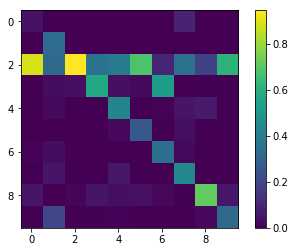

In [80]:
predictOnDataBase(model,41,"piczakData",8,9, 10)
from sklearn.preprocessing import normalize
scores = getScores("wholeTracks",8,9,10)
print (scores[1])
print (scores[0])
np.set_printoptions(precision=0)
print (100*np.diag(scores[0])/scores[0].sum(axis=0))
normscores =normalize(scores[0],norm='l1' ,axis=0)
plt.imshow(normscores)
plt.colorbar()
plt.show()

Epoch 1/1
3545/3545 [==============================] - 0s     
Epoch 1/1
2912/3545 [=======================>......] - ETA: 0s

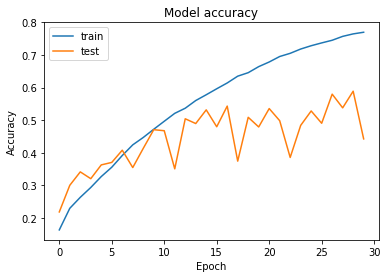

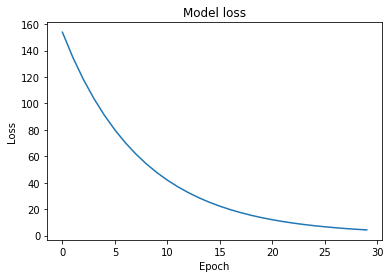

In [33]:
batches = [256]
lrs = [0.0001]
l2s = [0.3]
drops = [0.5]
for drop in drops:
    for l2 in l2s:
        for lr in lrs:
            for batch in batches:
                tr, tu, ls = regularNet(drop,l2,lr,batch)


In [55]:
tu[:][1]

[8.0144560137339234, 0.23613921489275597]

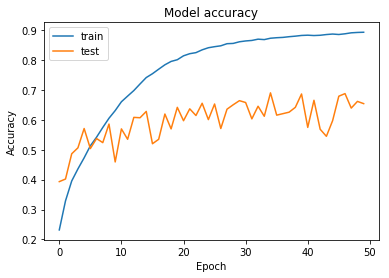

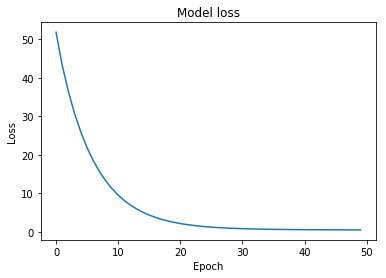

In [42]:
plt.plot(trSc)
plt.plot(tuSc)
plt.title('Model accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("regularnetalldrop05lr00001l201.png")
plt.show()
plt.plot(ls)
plt.title('Model loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

0.68858560794
[[ 39.   0.   8.   3.   2.  12.   0.  14.   2.   2.]
 [  5.  27.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  5.   2.  70.   7.   3.   1.   0.   1.   0.   1.]
 [  0.   0.   2.  74.   1.   0.   1.   0.   0.   1.]
 [ 19.   0.   0.   0.  77.   0.   0.   9.  31.   0.]
 [  6.   0.   5.   0.   0.  61.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   1.   0.  29.   0.   0.   0.]
 [  0.   0.   0.   0.   3.  12.   0.  54.   0.   0.]
 [  0.   0.   1.  13.   2.   0.   0.   0.  36.   8.]
 [ 26.   1.  14.   3.  11.   2.   0.   0.  10.  88.]]
[ 0.39  0.9   0.7   0.74  0.77  0.69  0.97  0.69  0.45  0.88]


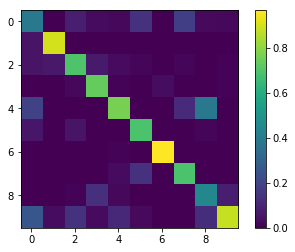

In [62]:
## print scores and graphic version
## confusion matrix, x - actual class, y - predicted class
from sklearn.preprocessing import normalize
scores = getScores(8)
print scores[1]
print scores[0]
np.set_printoptions(precision=2)
print np.diag(scores[0])/scores[0].sum(axis=0)
normscores =normalize(scores[0],norm='l1' ,axis=0)
plt.imshow(normscores)
plt.colorbar()
plt.show()


/fold8/131571-6-0-0.wav
75


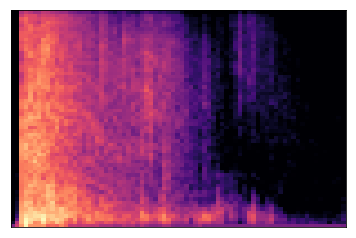

/fold8/145206-6-0-0.wav
49


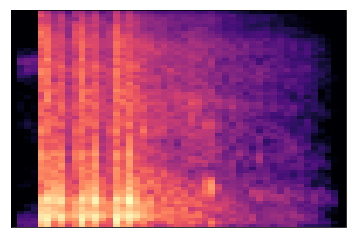

/fold8/145206-6-1-0.wav
58


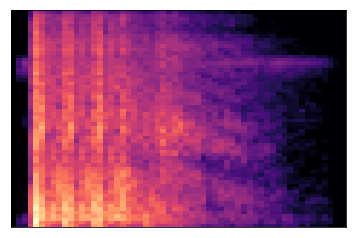

/fold8/145206-6-2-0.wav
38


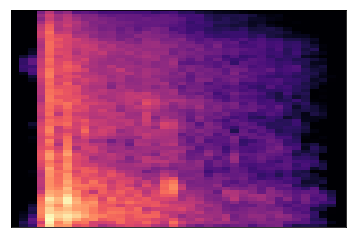

/fold8/145206-6-3-0.wav
48


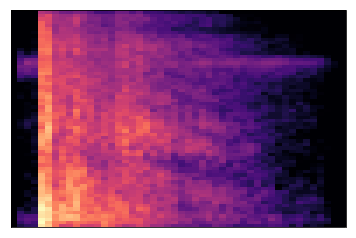

/fold8/7065-6-0-0.wav
118


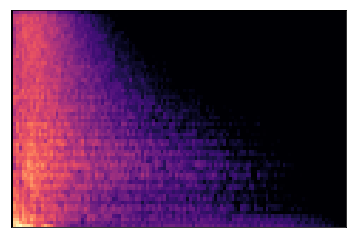

/fold9/136399-6-0-0.wav
131


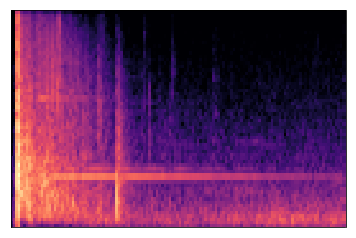

/fold9/136399-6-1-0.wav
144


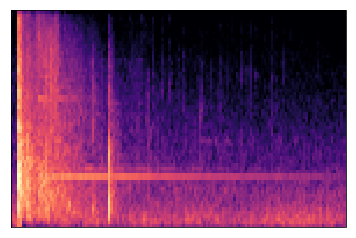

/fold9/136399-6-2-0.wav
127


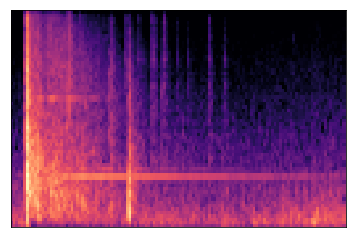

/fold9/136399-6-3-0.wav
116


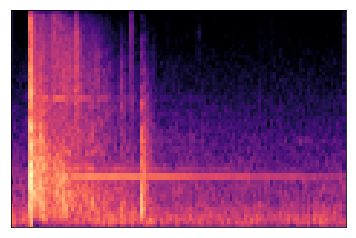

/fold9/136399-6-4-0.wav
77


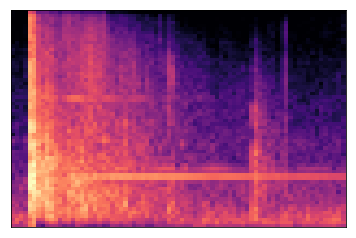

/fold9/136399-6-5-0.wav
93


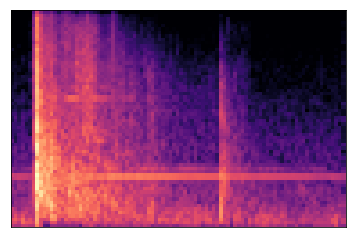

/fold9/136399-6-6-0.wav
76


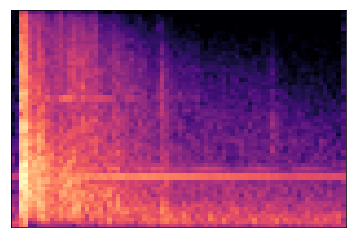

/fold9/136399-6-7-0.wav
103


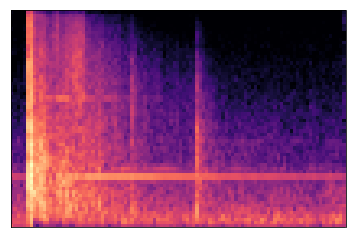

/fold9/136399-6-8-0.wav
61


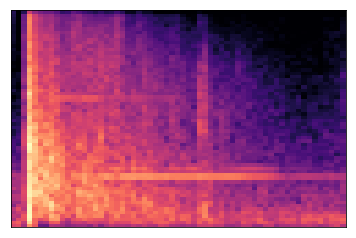

/fold9/136399-6-9-0.wav
80


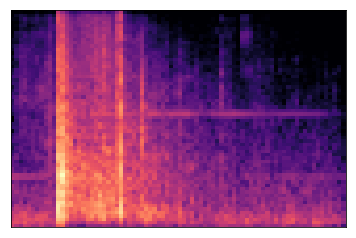

/fold9/157801-6-0-0.wav
99


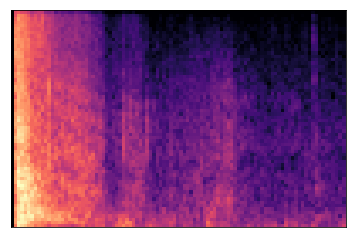

/fold9/25038-6-0-0.wav
66


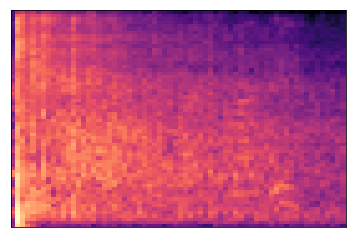

/fold9/87562-6-0-0.wav
119


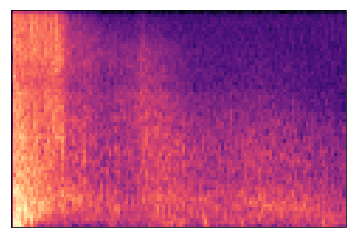

/fold10/169261-6-0-0.wav
65


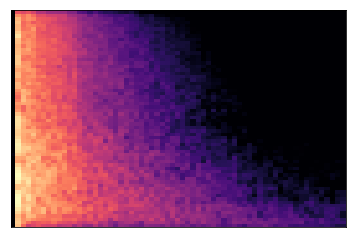

/fold10/200460-6-0-0.wav
75


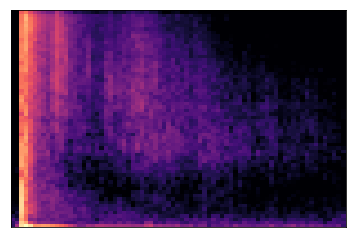

/fold10/200460-6-1-0.wav
71


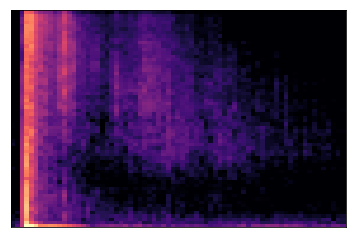

/fold10/25037-6-0-0.wav
52


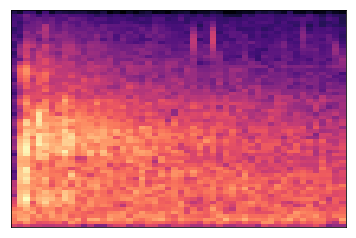

/fold10/25037-6-1-0.wav
52


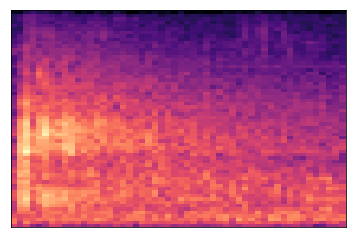

In [30]:
for x in findClips(actual=6, predicted = 3, folds= range(8,11)):
    showClip(x)

In [6]:
## AS WELL OUTDATED, SCORES ARE NOW BASED ON PREDICTIONS SAVED IN HDF5 FILE

#final scoring function. isnt used in training.
#CNN predicts classes for all parts of clip and sums probablities, chooses best
#scores is confusion matrix
scores = np.zeros((10,10))
for track,label in zip(testData,testLabels):
    tempD =[]
    iterator = 0
    ## if track is too short for even one window to predict, fill it up with zeros to one window size
    if track.shape[1]<16:
        t = track.shape[1]
        b = np.zeros((64,16))
        b[:, :-16+t]= track
        tempD.append(b)
    while (iterator+16<=track.shape[1]):
        tempD.append(track[:,iterator:iterator+16])
        iterator+=16
    tempD= np.array(tempD)
    tempD = np.expand_dims(tempD, axis=3)
    predicted = model.predict(tempD, batch_size=1, verbose=2)
    scores[predicted.sum(axis=0).argmax(),label]+=1

accuracy = scores.trace()/scores.sum()    
print accuracy

0.67332123412


[[  99.    0.    0.    7.    2.   26.    0.    5.    0.    1.]
 [   5.   71.    0.    2.    0.    0.    0.    0.    0.    0.]
 [  37.    5.  231.   29.   18.   30.    0.    6.   22.   25.]
 [   7.    2.   37.  235.   13.    6.   24.    0.   22.    7.]
 [  63.    0.    2.    1.  212.    0.    1.   47.   13.    1.]
 [   2.    0.   12.    5.    3.  170.    0.    0.    3.    1.]
 [   1.    0.    4.    2.    1.    0.   68.    1.    0.    0.]
 [  29.    0.    1.    1.   33.   20.    0.  197.    0.    0.]
 [  11.    0.    4.   10.    4.    0.    0.    0.  185.    7.]
 [  46.   17.    9.    8.   14.   18.    0.    0.    0.  258.]]


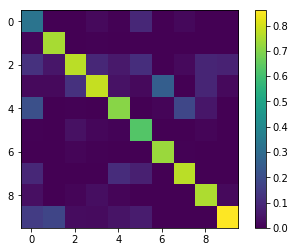

In [27]:
from sklearn.preprocessing import normalize

## print scores and graphic version
## confusion matrix, x - actual class, y - predicted class
scores = getScores(8,9,10)[0]
print scores
normscores =normalize(scores,norm='l1' ,axis=0)
plt.imshow(normscores)
plt.colorbar()
plt.show()

In [ ]:
def appendTracks(data,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    if sound.shape[0] > 2:
        data.append([sr, librosa.core.get_duration(y=sound,sr=sr), 1, int(fp.split("/")[1].split("-")[1])])
    else:
        data.append([sr, librosa.core.get_duration(y=sound,sr=sr), 2, int(fp.split("/")[1].split("-")[1])])

In [ ]:
from multiprocessing import Process, Lock, Pipe,Event



data = []

## per process method, extracts data from given fold and sends it to main process
def add(x,c):
    tempdata = []
    for file in glob.glob(x):
        appendTracks(tempdata, file)
            
    c.send(tempdata)
    del tempdata
        

ts = time.time()

if __name__ == '__main__':
    threads= []
    connections=[0]*10
    
    
    ## create threads, assign them methods and start 
    for x in xrange(1,11):
        connections[x-1], childPipe=Pipe()
        threads.append(Process(target=add, args=("fold"+str(x)+"/*.wav",childPipe)))         
        threads[x-1].start()
    
    ## wait for threads to finish, get data
    for x,y in zip(threads,connections):
        data.append(y.recv())

In [ ]:
temp = {}
for x in flattened[:,0]:
    if x in temp:
        temp[x] += 1
    else:
        temp[x] = 1
print temp

d = [[int(x),temp[x]] for x in temp]
print d
d = sorted(d)

sr = [x[0] for x in d]
count = [x[1] for x in d]
print sr, count


import matplotlib
y_pos = np.arange(len(count))

matplotlib.rc('font', family='Arial')
plt.rcdefaults()

fig, ax = plt.subplots()

ax.bar(y_pos, count, align='center',
        color='green', alpha = 0.6)
ax.set_xticks(y_pos)
ax.set_xticklabels(sr)
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(u'Szybkość próbkowania [Sample/s]')
ax.set_ylabel(u'Liczba nagrań')
ax.set_title(u'Rozłożenie nagrań w zależności od szybkości próbkowania')
plt.tight_layout()
plt.savefig('probkowanie.png')
plt.show()

In [ ]:
n, bins, patches = plt.hist(flattened[:,1], 8, facecolor='green', alpha=0.6)



plt.xlabel(u'Czas trwania [s]')
plt.ylabel(u'Liczna nagrań')
plt.title(u'Rozłożenie nagrań w zależności od czasu trwania')

plt.tight_layout()
plt.savefig('czastrwania.png')
plt.show()

In [ ]:
temp = {}
for x in flattened[:,3]:
    if x in temp:
        temp[x] += 1
    else:
        temp[x] = 1
print temp

d = [[int(x),temp[x]] for x in temp]
print d
d = sorted(d)

cl = [x[0] for x in d]
count = [x[1] for x in d]
print cl, count

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

index = np.arange(len(cl))
bar_width = 0.5


rects1 = plt.bar(index, count, bar_width,
                 alpha = 0.6,
                 color='g')


plt.xlabel('Rodzaj nagrania')
plt.ylabel(u'Liczba nagrań')
plt.title(u'Rozłożenie nagrań w zależności od przedmiotu nagrania')
plt.xticks(index, ('Klimatyzator', 'Klakson', 'Dzieci', 'Pies', 'Wiertarka', 'Silnik',u'Wystrzał', u'Młot pneumatyczny', 'Syrena', 'Muzyka'))

plt.tight_layout()
plt.savefig('klasy.png')
plt.show()

Some charts used in finetuning of previous NN

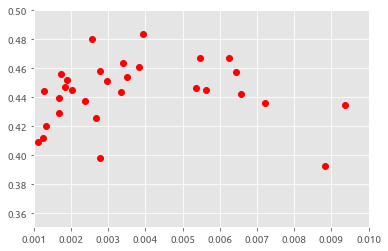

In [43]:
plt.plot(rates[:,2],rates[:,0],'ro')
plt.axis([0.001,0.01,0.35,0.5])
plt.show()
#128 batch - f(learning_Rate)=score

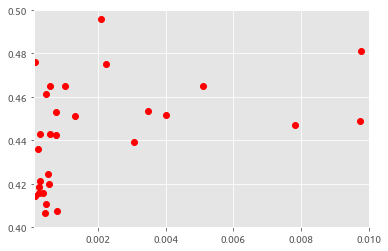

In [50]:
plt.plot(rates1[:,3],rates1[:,0],'ro')
plt.axis([0.0001,0.01,0.4,0.5])
plt.show()
#128 batch - f(L2 lambda)=score, lr=0.0038